In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
# Delete warning 
warnings.simplefilter("ignore")

# Data
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Model Evalutions
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/clothessizeprediction/final_test.csv


In [3]:
df_raw = pd.read_csv('/kaggle/input/clothessizeprediction/final_test.csv')
df_raw.head()

,weight,age,height,size
0,62,28.0,172.72,XL
1,59,36.0,167.64,L
2,61,34.0,165.10,M
3,65,27.0,175.26,L
4,62,45.0,172.72,M


In [4]:
df_raw['size'].value_counts()

size
M       29712
S       21924
XXXL    21359
XL      19119
L       17587
XXS      9964
XXL        69
Name: count, dtype: int64

<Axes: xlabel='size', ylabel='count'>

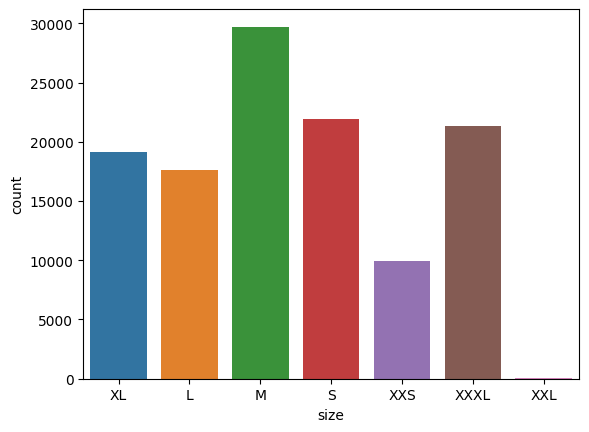

In [5]:
sns.countplot(x=df_raw["size"])

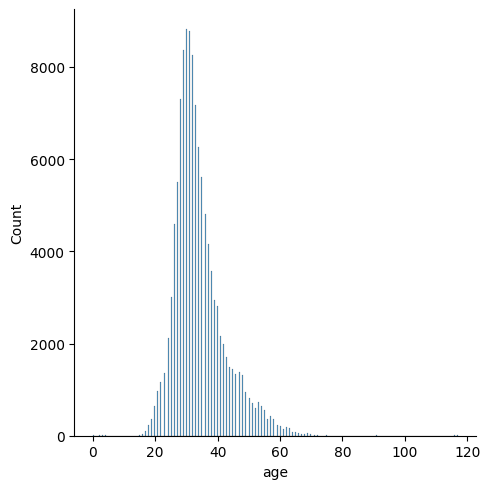

In [6]:
sns.displot(df_raw["age"])

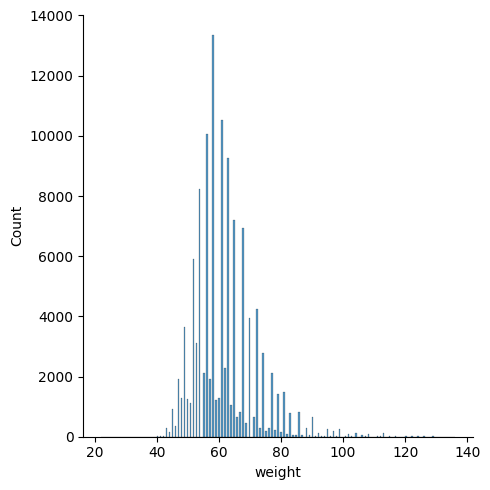

In [7]:
sns.displot(df_raw["weight"])

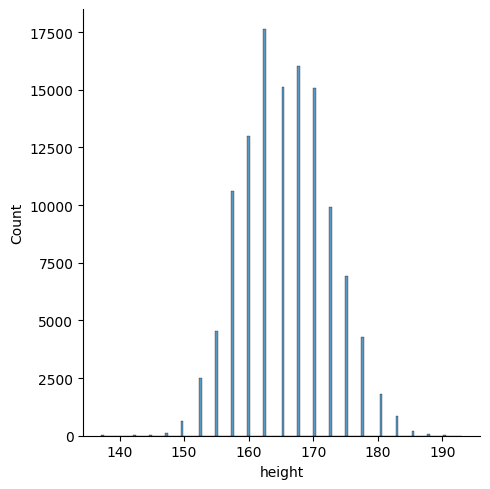

In [8]:
sns.displot(df_raw["height"])

<Axes: ylabel='Density'>

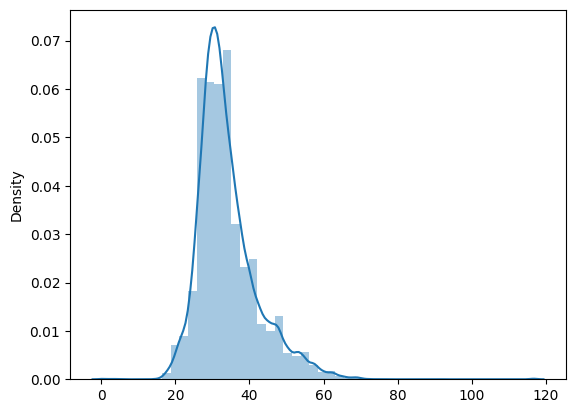

In [9]:
sns.distplot(x=df_raw['age'])

In [10]:
df_raw.describe()

,weight,age,height
count,119734.000000,119477.000000,119404.000000
mean,61.756811,34.027311,165.805794
std,9.944863,8.149447,6.737651
min,22.000000,0.000000,137.160000
25%,55.000000,29.000000,160.020000
50%,61.000000,32.000000,165.100000
75%,67.000000,37.000000,170.180000
max,136.000000,117.000000,193.040000


# Removing Outliers with Z-scores

In [11]:
cleaned_dfs = []
zscore_threshold = 3
for size_type in df_raw['size'].unique():
    ndf = df_raw[['age', 'height', 'weight']][df_raw['size'] == size_type]
    zscore = np.abs((ndf - ndf.mean()) / ndf.std())
    ndf = ndf[(zscore < zscore_threshold).all(axis=1)]
    ndf['size'] = size_type
    cleaned_dfs.append(ndf)
    df_cleaned = pd.concat(cleaned_dfs)
    print(df_cleaned.head())

     age  height  weight size
0   28.0  172.72      62   XL
24  29.0  177.80      74   XL
25  32.0  160.02      64   XL
28  31.0  154.94      58   XL
34  36.0  162.56      68   XL
     age  height  weight size
0   28.0  172.72      62   XL
24  29.0  177.80      74   XL
25  32.0  160.02      64   XL
28  31.0  154.94      58   XL
34  36.0  162.56      68   XL
     age  height  weight size
0   28.0  172.72      62   XL
24  29.0  177.80      74   XL
25  32.0  160.02      64   XL
28  31.0  154.94      58   XL
34  36.0  162.56      68   XL
     age  height  weight size
0   28.0  172.72      62   XL
24  29.0  177.80      74   XL
25  32.0  160.02      64   XL
28  31.0  154.94      58   XL
34  36.0  162.56      68   XL
     age  height  weight size
0   28.0  172.72      62   XL
24  29.0  177.80      74   XL
25  32.0  160.02      64   XL
28  31.0  154.94      58   XL
34  36.0  162.56      68   XL
     age  height  weight size
0   28.0  172.72      62   XL
24  29.0  177.80      74   XL
25  32.0  

In [12]:
df_raw.isna().sum()

weight      0
age       257
height    330
size        0
dtype: int64

In [13]:
df_raw["age"] = df_raw["age"].fillna(df_raw['age'].median())
df_raw["height"] = df_raw["height"].fillna(df_raw['height'].median())
df_raw["weight"] = df_raw["weight"].fillna(df_raw['weight'].median())

In [14]:
# Mapping clothes size from strings to numeric
df_raw['size'] = df_raw['size'].map({"XXS": 1,
                                     "S": 2,
                                     "M": 3,
                                     "L": 4,
                                     "XL": 5,
                                     "XXL": 6,
                                     "XXXL": 7})

In [15]:
df_raw

,weight,age,height,size
0,62,28.0,172.72,5
1,59,36.0,167.64,4
2,61,34.0,165.10,3
3,65,27.0,175.26,4
4,62,45.0,172.72,3
...,...,...,...,...
119729,63,42.0,175.26,3
119730,45,29.0,154.94,2
119731,61,31.0,172.72,3
119732,74,31.0,167.64,5


# Feature Engineering
* **bmi** (body-mass-index) 
* **weight-squared** 

In [16]:
#Feature Engineering
df_raw["bmi"] = df_raw['weight'] / (df_raw['height']**2/100)
df_raw["weight-squared"] = df_raw["weight"] * df_raw["weight"]
df_raw["age-size"] = df_raw["age"] * df_raw["size"]

# Splitting data

In [17]:
X = df_raw.drop(["size"], axis=1) # Features
y = df_raw['size'] # Target

In [18]:
X.head()

,weight,age,height,bmi,weight-squared,age-size
0,62,28.0,172.72,0.207829,3844,140.0
1,59,36.0,167.64,0.209941,3481,144.0
2,61,34.0,165.10,0.223787,3721,102.0
3,65,27.0,175.26,0.211616,4225,108.0
4,62,45.0,172.72,0.207829,3844,135.0


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.10)

In [20]:
len(X_train), len(X_test)

(107760, 11974)

# Training Model

In [21]:
# Naive Bayes
models = {"Naive Bayes" : GaussianNB()}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    # Set random seed
    np.random.seed(18)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit model to data
        model.fit(X_train, y_train)
        # Evaluate model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
        
    return model_scores

In [22]:
model_score = fit_and_score(models, X_train, X_test, y_train, y_test)
model_score

{'Naive Bayes': 0.6961750459328545}

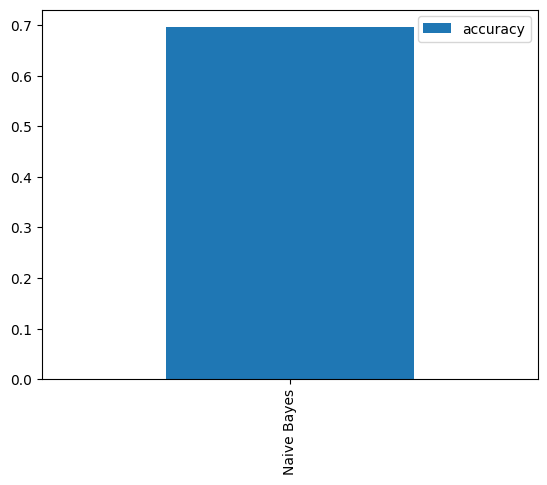

In [23]:
model_compare = pd.DataFrame(model_score, index=['accuracy'])
model_compare.T.plot.bar();